<a href="https://colab.research.google.com/github/Udithkanchana/IOT_Humidity_Predictions/blob/main/IOT_Humidity_prdiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/SLIIT/Data_Science/Internet_of_Things

/content/gdrive/MyDrive/SLIIT/Data_Science/Internet_of_Things


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing


In [ ]:
#import the csv file to extract data
df=pd.read_csv('colombo_rh_2012-2018.csv') #index_col='DATE',parse_dates=True this is to ensure that panda understand that the 'DATE' is not string & it's a date value.
df=df.dropna() #drop null values
print('Shape of data',df.shape)
df.head()

Shape of data (4383, 7)


,station_id,station_name,element_name,year,month,day,obs_val
0,43466,COLOMBO,RHMAX,2012,1,1,91.0
1,43466,COLOMBO,RHMAX,2012,1,2,90.0
2,43466,COLOMBO,RHMAX,2012,1,3,89.0
3,43466,COLOMBO,RHMAX,2012,1,4,89.0
4,43466,COLOMBO,RHMAX,2012,1,5,95.0


Lets make month, year, day one single column.

In [ ]:
df['date'] = pd.to_datetime(df[['day','month','year']], format='%d-%m-%Y')

In [ ]:
# drop the original columns
df.drop(['day','month','year','station_id','station_name'], axis=1, inplace=True)

# show the resulting dataframe
print(df)


     element_name  obs_val       date
0           RHMAX     91.0 2012-01-01
1           RHMAX     90.0 2012-01-02
2           RHMAX     89.0 2012-01-03
3           RHMAX     89.0 2012-01-04
4           RHMAX     95.0 2012-01-05
...           ...      ...        ...
4398        RHMAX     90.0 2018-12-27
4399        RHMAX     88.0 2018-12-28
4400        RHMAX     76.0 2018-12-29
4401        RHMAX     81.0 2018-12-30
4402        RHMAX     82.0 2018-12-31

[4383 rows x 3 columns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4383 entries, 0 to 4402
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   element_name  4383 non-null   object        
 1   obs_val       4383 non-null   float64       
 2   date          4383 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 137.0+ KB


In [ ]:
df[df['date']=='2015-01-10']

,element_name,obs_val,date
1125,RHMAX,72.0,2015-01-10
1490,RHMIN,60.0,2015-01-10


It appears that there are some duplicate values in the dataset. For one date there are Min & Max figure for some records. Hence, lets try to get the Max value only from those duplicates while non-duplicates remains the same.

In [ ]:
# Remove duplicates
df = df.groupby(['date', 'element_name'], as_index=False)['obs_val'].max()

# If duplicates exist, keep only RHMAX
mask = df.duplicated(subset=['date'], keep=False)
df.loc[mask & (df['element_name'] == 'RHMIN'), 'element_name'] = 'RHMAX'
df.loc[mask & (df['element_name'] == 'RHMIN'), 'obs_val'] = df.loc[mask & (df['element_name'] == 'RHMAX'), 'obs_val'].values

Lets check the duplicates again.

In [ ]:
# check for duplicates in the 'name' column
duplicates=df.duplicated(subset='date', keep=False)

# print the rows with duplicates
print(df[duplicates])

Empty DataFrame
Columns: [date, element_name, obs_val]
Index: []


No duplicates found. 

Now we have to test whether the data set is stationary or not. Use Augmented Dick-fuller (ADF) for that.

* null hypotheis : the series is non-stationary
* alternative hypothesis : the series is stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.obs_val.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.943395
p-value: 0.000000


Will check the seasonal component to identify whether there is seasonality in the time series. But generally, if the time series is stationary, there cannot be any seasonal component.

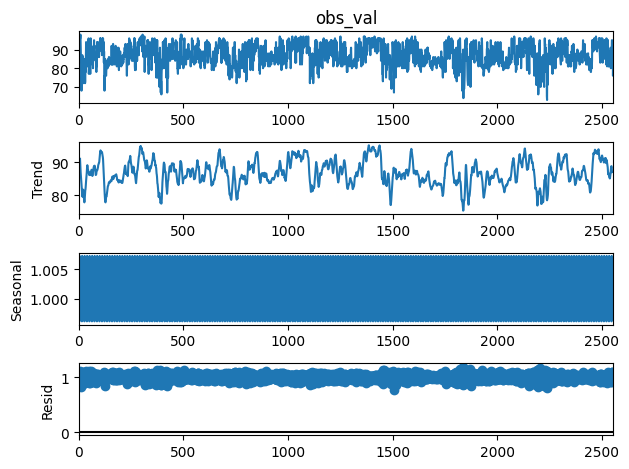

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition using moving averages
decomposition = seasonal_decompose(df.obs_val, model='multiplicative', period=12)

# Plot the seasonal decomposition
fig = decomposition.plot()

Since the seasonal component is relatively flat, there is no seasonality in the time series. This is obvious actually with the p-value of ADF test is less than 0.05 which means the time series is stationary.

Since the p-value & ADF statistic value are less than 0.05, the null hypothesis can be rejected at a 0.95 significant level. So at a significant level of 95%, we can say that the time series is stationary. Hence not need to differentiate the series. So the d=0 because the time series is stationary.

Next we have to find the P & M values. (order of AR & MA terms). We can do that using the Partial Autocorrelation (PACF) plot & ACF plot as follows. (But we can easily take them using 'autoarmia' but it's not accurate all the times. So here we move forward in the traditional way.)

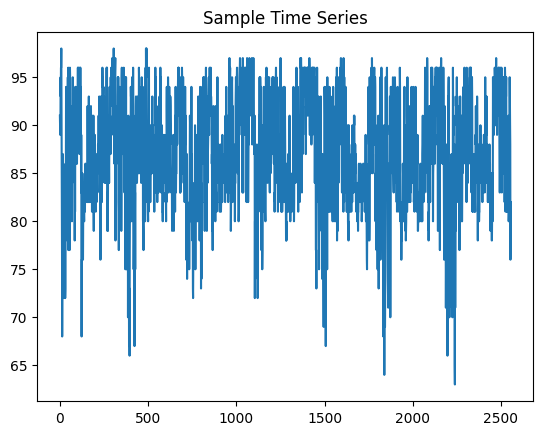

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


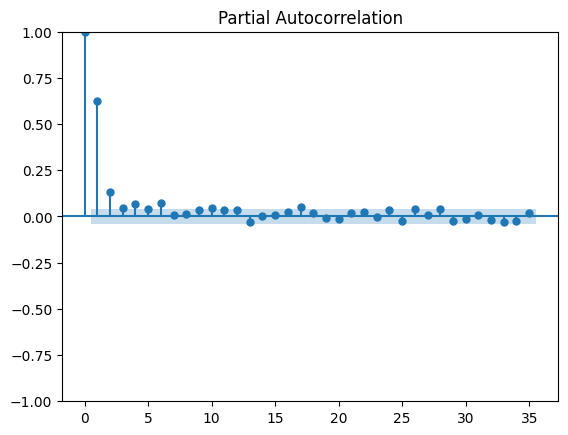

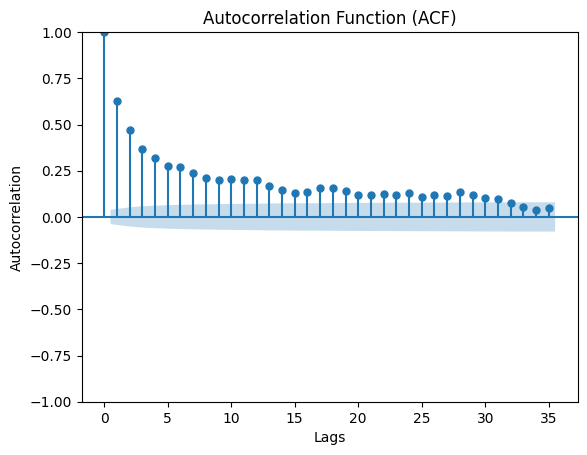

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# plot the time series
plt.plot(df.obs_val)
plt.title('Sample Time Series')
plt.show()

# plot PACF to determine AR(p) term
plot_pacf(df.obs_val)

# plot ACF to determine MA(q) term
plot_acf(df.obs_val)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

According the PACF & ACF plots, the p=4,q=31. So lets fit the model & check the accuracy of the model.

In [ ]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

#Fit ARIMA Model
model = ARIMA(df.obs_val, order=(4,0,31))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                obs_val   No. Observations:                 2557
Model:                ARIMA(4, 0, 31)   Log Likelihood               -7379.147
Date:                Fri, 05 May 2023   AIC                          14832.294
Time:                        04:04:10   BIC                          15048.618
Sample:                             0   HQIC                         14910.740
                               - 2557                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.8698      0.423    205.168      0.000      86.040      87.700
ar.L1          0.9393      1.141      0.823      0.410      -1.297       3.176
ar.L2         -0.7187      1.520     -0.473      0.6

Sigma2 & const are significant, so that means the ARIMA model is a good fit for the data. (as p-value is less than 0.05) 

Now let us check whether there is constant variance & mean.

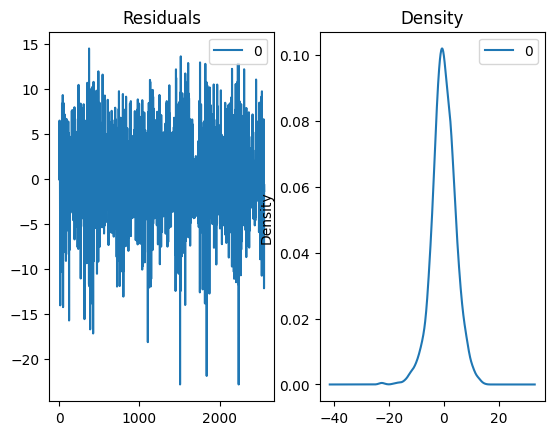

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Zero mean & variance mean that the residual error is fine with the model.

Now let us predict the testing data & plot it with the actual testing vaules.

<Axes: >

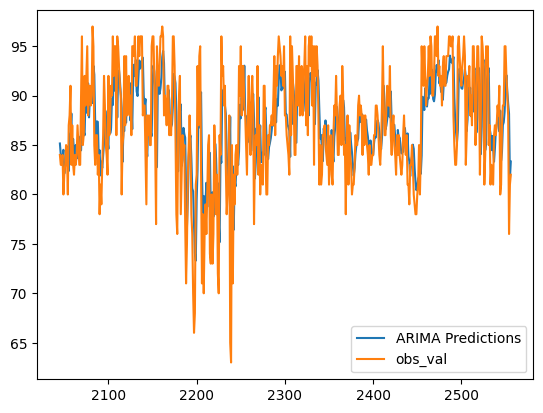

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=False)

start=len(train)
end=len(train)+len(test)-1
pred=model_fit.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['obs_val'].plot(legend=True)

Lets check the accuuracy of the madel by checking the 'root mean squared error'

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['obs_val'].mean()
rmse=sqrt(mean_squared_error(pred,test['obs_val']))
print(rmse)

4.40519227516903


Lets predict the future values upto 2024

<Axes: >

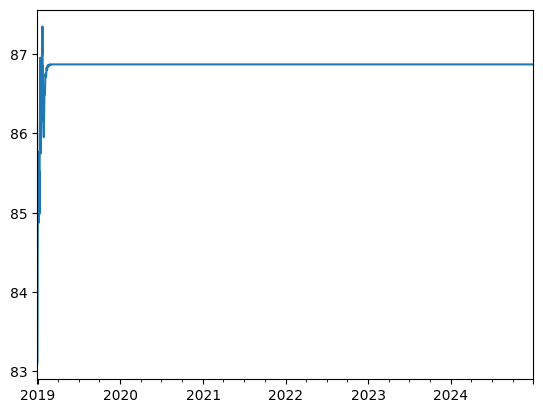

In [ ]:
start_date = '2018-12-31'

end_date = '2024-12-31'

date_range = pd.date_range(start=start_date, end=end_date)

predictions_future = model_fit.forecast(steps=len(date_range))

predictions_future.index = date_range
predictions_future

# Save the forecast DataFrame as a CSV file
pd.DataFrame(predictions_future).reset_index().to_csv('forecast3.csv', index=False)

predictions_future.plot()